In [34]:
import requests  
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import numpy as np
import string

[nltk_data] Downloading package stopwords to C:\Users\Rico
[nltk_data]     Mesias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# --- 1. Memuat Data ---
data = pd.read_csv("data/updatemergedata.csv")

# --- 2. Preprocessing Data ---
# Encode categorical variables
label_encoder = LabelEncoder()
data['Level'] = label_encoder.fit_transform(data['Level'])
data['Price'] = data['Price'].map({'Berbayar': 1, 'Gratis': 0})

# Gabungkan fitur teks menjadi satu kolom
indonesian_stopwords = stopwords.words('indonesian')
data['Combined Summary'] = (
    data['Learning Path'] + ' ' +
    data['Learning Path Summary'] + ' ' +
    data['Course Name_x'] + ' ' +
    data['Course Summary']
)

In [37]:
# TF-IDF untuk fitur teks
factory = StopWordRemoverFactory()
indonesian_stopwords = list(factory.get_stop_words())  # Ubah ke list

# Gunakan di TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=indonesian_stopwords)
tfidf_matrix = tfidf.fit_transform(data['Combined Summary']).toarray()

# Scaling fitur numerik
scaler = StandardScaler()
numerical_features = data[['Level', 'Price']].values
scaled_numerical_features = scaler.fit_transform(numerical_features)

# Gabungkan fitur teks dan numerik menggunakan vectorization
X_combined = np.concatenate([tfidf_matrix, scaled_numerical_features], axis=1)

In [38]:
# # Load model dan tokenizer BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# # Fungsi untuk mendapatkan embedding teks dengan BERT
# def get_bert_embeddings(text, tokenizer, model):
#     inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     outputs = model(**inputs)
#     return outputs.last_hidden_state[:, 0, :].detach().numpy()  # Gunakan CLS token sebagai representasi

# # Generate embedding untuk semua teks
# bert_embeddings = np.vstack(data['Combined Summary'].apply(lambda x: get_bert_embeddings(x, tokenizer, bert_model)))

# # Gabungkan embedding BERT dengan fitur numerik
# numerical_features = data[['Level', 'Price']].values

# scaler = StandardScaler()
# scaled_numerical = scaler.fit_transform(numerical_features)

# X_combined = np.hstack((bert_embeddings, scaled_numerical))

In [39]:
# TF-IDF untuk fitur teks
tfidf = TfidfVectorizer(stop_words=indonesian_stopwords)
tfidf_matrix = tfidf.fit_transform(data['Combined Summary']).toarray()

# Scaling fitur numerik
scaler = StandardScaler()
numerical_features = data[['Level', 'Price']].values
scaled_numerical_features = scaler.fit_transform(numerical_features)

# Gabungkan fitur teks dan numerik menggunakan vectorization
X_combined = np.concatenate([tfidf_matrix, scaled_numerical_features], axis=1)

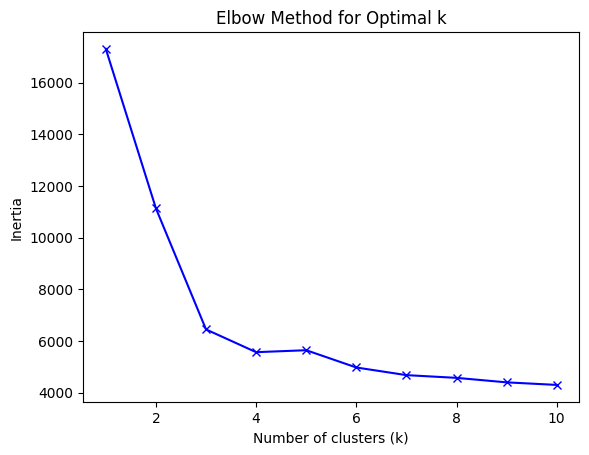

In [40]:
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_combined)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [46]:
# --- 3. Melatih Model KMeans ---
optimal_k = 4  # Sesuaikan jumlah cluster sesuai kebutuhan
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_combined)

# Simpan model dan data
joblib.dump(tfidf, 'tfidf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')
data.to_csv('data_with_clusters.csv', index=False)
print("Model dan data dengan cluster berhasil disimpan.")

Model dan data dengan cluster berhasil disimpan.


In [47]:
# Fungsi untuk ambil repositori GitHub pengguna
def get_github_repos(username):
    url = f'https://api.github.com/users/{username}/repos'
    response = requests.get(url)
    if response.status_code == 200:
        return [repo['language'] for repo in response.json() if repo['language']]  # Ambil bahasa pemrograman
    return []

In [48]:
def recommend_courses_with_kmeans(data, user_preferences, programming_languages, github_languages, top_n=5):
    """
    Merekomendasikan kursus berdasarkan preferensi pengguna menggunakan KMeans dan Cosine Similarity.
    """
    # Gabungkan preferensi pengguna
    preferences = user_preferences + programming_languages + github_languages
    combined_summary = ' '.join(preferences)
    
    # Load model TF-IDF dan scaler
    tfidf = joblib.load('tfidf_model.pkl')
    scaler = joblib.load('scaler.pkl')
    kmeans = joblib.load('kmeans_model.pkl')
    
    # Proses input pengguna
    tfidf_vector = tfidf.transform([combined_summary]).toarray()
    scaled_numerical_features = scaler.transform([[0, 0]])  # Default untuk fitur numerik
    X_input = np.hstack((tfidf_vector, scaled_numerical_features))
    
    # Prediksi cluster
    cluster_label = kmeans.predict(X_input)[0]
    
    # Filter data berdasarkan cluster yang sama
    cluster_data = data[data['Cluster'] == cluster_label]
    cluster_tfidf_matrix = tfidf.transform(cluster_data['Combined Summary']).toarray()

    # Hitung kemiripan dengan item dalam cluster
    similarities = cosine_similarity(tfidf_vector, cluster_tfidf_matrix)[0]
    cluster_data['Similarity'] = similarities  # Tambahkan kolom kemiripan
    
    # Sortir berdasarkan kemiripan dan ambil kursus unik
    sorted_data = cluster_data.sort_values(by='Similarity', ascending=False)
    unique_courses = sorted_data.drop_duplicates(subset=['Course Name_x']).head(top_n)
    
    # Hasilkan rekomendasi
    recommendations = unique_courses[['Course Name_x', 'Similarity']]
    
    # Penjelasan rekomendasi
    explanations = [
        f"Recommended because it matches your preference: {preferences}"
        for _ in range(len(recommendations))
    ]
    return recommendations, explanations

# --- 4. Rekomendasi untuk Pengguna ---
user_preferences = ['Mobile Development', 'Web Development', 'Kotlin', 'Android']
programming_languages = ['Java', 'Kotlin']
github_username = 'ricomessi'  # Ganti dengan username GitHub pengguna

# Ambil bahasa dari repositori GitHub
github_languages = get_github_repos(github_username)

# Dapatkan rekomendasi
recommendations, explanations = recommend_courses_with_kmeans(
    data, user_preferences, programming_languages, github_languages, top_n=5
)

# Tampilkan hasil
print("\nTop Recommended Courses:")
print(recommendations)

print("\nExplanation for Recommendations:")
for explanation in explanations:
    print(explanation)



Top Recommended Courses:
                                          Course Name_x  Similarity
377                   Belajar Prinsip Pemrograman SOLID    0.070997
5297  Belajar Membuat Augmented Reality dengan Lens ...    0.000000

Explanation for Recommendations:
Recommended because it matches your preference: ['Mobile Development', 'Web Development', 'Kotlin', 'Android', 'Java', 'Kotlin', 'HTML', 'Python', 'Python', 'Java', 'Python', 'PHP', 'PHP', 'Jupyter Notebook', 'PHP', 'HTML', 'PHP', 'PHP', 'PHP']
Recommended because it matches your preference: ['Mobile Development', 'Web Development', 'Kotlin', 'Android', 'Java', 'Kotlin', 'HTML', 'Python', 'Python', 'Java', 'Python', 'PHP', 'PHP', 'Jupyter Notebook', 'PHP', 'HTML', 'PHP', 'PHP', 'PHP']


C:\Users\Rico Mesias\AppData\Local\Temp\ipykernel_452\788528472.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Similarity'] = similarities  # Tambahkan kolom kemiripan


In [49]:
sil_score = silhouette_score(X_combined, data['Cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.25798238097235243


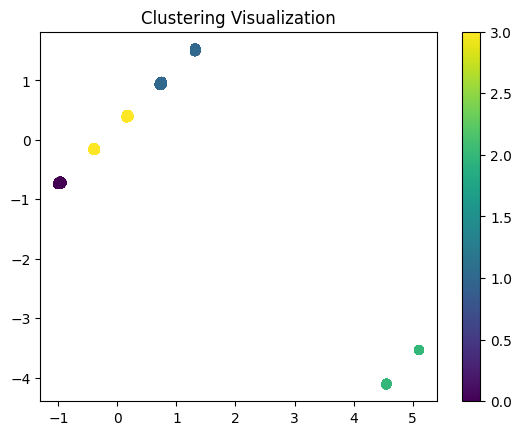

In [50]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_combined)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['Cluster'], cmap='viridis')
plt.colorbar()
plt.title('Clustering Visualization')
plt.show()

In [36]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_combined)
    scores.append(silhouette_score(X_combined, kmeans.labels_))

optimal_k = scores.index(max(scores)) + 2
print(f"Optimal number of clusters: {optimal_k}")


Optimal number of clusters: 2


In [12]:
!pip install gensim

In [13]:
!pip install transformers

In [14]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install Sastrawi


Note: you may need to restart the kernel to use updated packages.


C:\Users\Rico Mesias\OneDrive\Documents\VsCode\DicodingCompany\venv\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


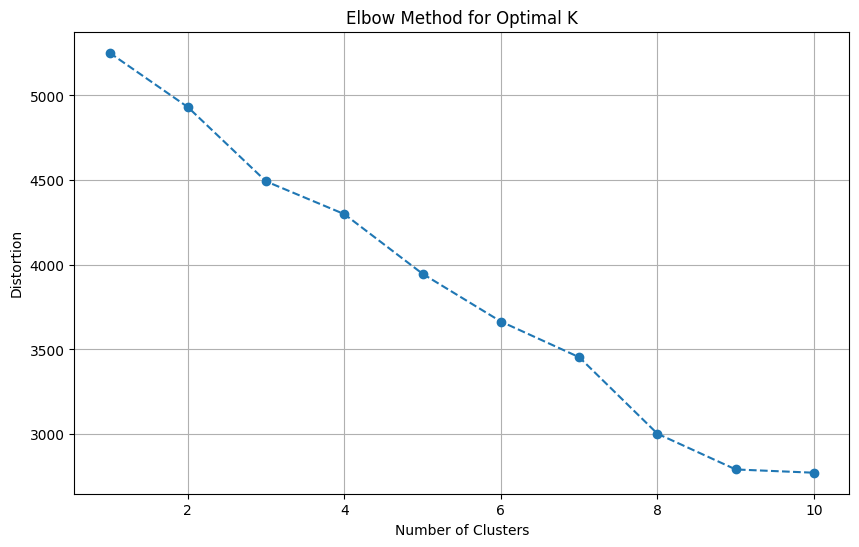

Masukkan minat atau topik pembelajaran yang ingin dikembangkan (misalnya: Machine Learning, Web Development):  Web Development, Python, Javascript



Top 5 Recommended Learning Paths based on user preferences:
                Learning Path  Similarity
2335  Front-End Web Developer    0.372121
2374  Front-End Web Developer    0.372121
2364  Front-End Web Developer    0.372121
2365  Front-End Web Developer    0.372121
2366  Front-End Web Developer    0.372121


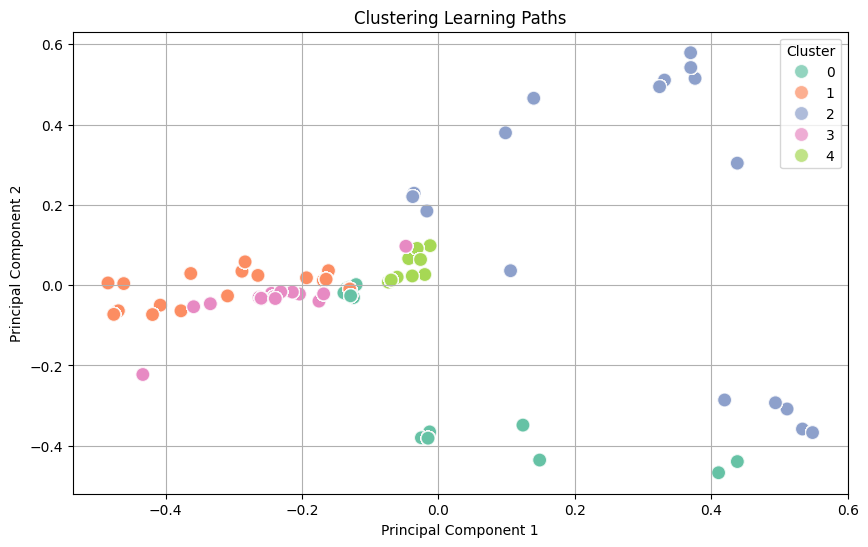

In [52]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# --- 1. Memuat Data ---
data = pd.read_csv("data/updatemergedata.csv")

# --- 2. Preprocessing Data ---
# Encode categorical variables
label_encoder = LabelEncoder()
data['Level'] = label_encoder.fit_transform(data['Level'])  # Encode Level into numerical values
data['Price'] = data['Price'].map({'Berbayar': 1, 'Gratis': 0})  # Encode Price into binary (1: Berbayar, 0: Gratis)

# Gabungkan fitur teks menjadi satu kolom
indonesian_stopwords = stopwords.words('indonesian')
data['Combined Summary'] = (
    data['Learning Path'] + ' ' +
    data['Learning Path Summary'] + ' ' +
    data['Course Name_x'] + ' ' +
    data['Course Summary']
)

# Menghilangkan stopwords
data['Combined Summary'] = data['Combined Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in indonesian_stopwords]))

# --- 3. Vektorisasi Fitur Teks ---
# Menggunakan TfidfVectorizer untuk vektorisasi teks
vectorizer = TfidfVectorizer(stop_words=indonesian_stopwords)
X = vectorizer.fit_transform(data['Combined Summary'])

# --- 4. Clustering dengan KMeans ---
# Menentukan jumlah cluster dengan metode Elbow
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot Elbow Curve untuk menentukan k optimal
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), distortions, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.grid(True)
plt.show()

# Berdasarkan plot elbow, pilih jumlah cluster yang optimal
optimal_clusters = 5  # misalnya, kita memilih 5 cluster

# Melakukan clustering menggunakan KMeans
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
data['Cluster'] = kmeans.fit_predict(X)

# --- 5. Rekomendasi Berdasarkan Clustering ---
# Misalnya, kita ingin merekomendasikan jalur pembelajaran berdasarkan cluster pengguna
# Kita dapat mencari cluster dengan kesamaan fitur teks tertinggi dengan preferensi pengguna
def get_user_preferences():
    preferences = input("Masukkan minat atau topik pembelajaran yang ingin dikembangkan (misalnya: Machine Learning, Web Development): ")
    return preferences

# Vektorisasi preferensi pengguna
user_preferences = get_user_preferences()
user_vector = vectorizer.transform([user_preferences])

# Menghitung kesamaan kosinus antara preferensi pengguna dan data yang telah dikelompokkan
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = cosine_similarity(user_vector, X)
data['Similarity'] = cosine_similarities.flatten()

# Menampilkan 5 rekomendasi teratas berdasarkan kesamaan tertinggi
recommendations = data.sort_values(by='Similarity', ascending=False).head(5)
print("\nTop 5 Recommended Learning Paths based on user preferences:")
print(recommendations[['Learning Path', 'Similarity']])

# --- 6. Visualisasi Hasil Clustering ---
# Menggunakan PCA untuk mereduksi dimensi menjadi 2 untuk visualisasi
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())

# Menampilkan hasil PCA dalam plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data['Cluster'], palette='Set2', s=100, alpha=0.7)
plt.title('Clustering Learning Paths')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
